# 0.0 IMPORTS

In [201]:
import pandas as pd
import seaborn as sns
import umap.umap_ as umap
import numpy as np
import re

from sklearn import cluster as c
from matplotlib import pyplot as plt
from sklearn import metrics as m
from sklearn import preprocessing as pp
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## 0.1. Auxiliar Functions

## 0.2. Load Data

In [202]:
data_raw = pd.read_csv('datasets/Ecommerce.csv', encoding = 'unicode_escape')

data_raw = data_raw.drop(columns = ['Unnamed: 8'])

# 1.0. Data Description

In [203]:
df1 = data_raw.copy()

## 1.1. Rename Columns

In [204]:
df1.columns = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']

## 1.2. Data Dimensions

In [205]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of cols: {df1.shape[1]}')

Number of rows: 541909
Number of cols: 8


## 1.3. Data Types

In [206]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [207]:
df1.isnull().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [208]:
df1 = df1.dropna(subset=['description', 'customer_id'])

In [209]:
print(f'Total quantity of NA: {df1.isnull().sum().sum()}')

Total quantity of NA: 0


## 1.6. Change Types

In [210]:
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

## 1.7. Descriptive Statistics

In [211]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [212]:
min_      = pd.DataFrame(num_attributes.apply(np.min)).T
max_      = pd.DataFrame(num_attributes.apply(np.max)).T
mean_     = pd.DataFrame(num_attributes.apply(np.mean)).T
median_   = pd.DataFrame(num_attributes.apply(np.median)).T
std_      = pd.DataFrame(num_attributes.apply(np.std)).T
range_    = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
skew_     = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
kurtosis_ = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
data_statistical = pd.concat([min_, max_, range_, mean_, median_, std_, skew_, kurtosis_]).T.reset_index()
data_statistical.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [213]:
data_statistical

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.0,80995.0,161990.0,12.061303,5.00,248.693064,0.182663,94317.563673
1,unit_price,0.0,38970.0,38970.0,3.460471,1.95,69.315077,452.219019,246924.542988
2,customer_id,12346.0,18287.0,5941.0,15287.690570,15152.00,1713.598197,0.029835,-1.179982


#### 1.7.1.1 Numerical Attributes - Investigating

1. Negative Quantity (Devolution?)
2. Unit Price == 0 (Sales Promotion?)

### 1.7.2 Categorical Attributes

In [214]:
# INVOICE NUMBER

#cat_attributes.loc[cat_attributes['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), 'invoice_no'].drop_duplicates()
len(cat_attributes.loc[cat_attributes['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), 'invoice_no'].drop_duplicates())

3654

In [215]:
# STOCK CODE

#at_leat_one_string = len(cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('[^0-9]+', x))), 'stock_code'])
#at_leat_one_string

#cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()
df1.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), :].head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
45,536370,POST,POSTAGE,3,2016-11-29,18.00,12583.0,France
141,C536379,D,Discount,-1,2016-11-29,27.50,14527.0,United Kingdom
386,536403,POST,POSTAGE,1,2016-11-29,15.00,12791.0,Netherlands
1123,536527,POST,POSTAGE,1,2016-11-29,18.00,12662.0,Germany
2239,536569,M,Manual,1,2016-11-29,1.25,16274.0,United Kingdom


# 2.0. Data Filtering

In [216]:
df2 = df1.copy()

In [217]:
# Numerical Attributes #
# Unit price > 0.0
df2 = df2.loc[df2['unit_price'] > 0.010, :]

# stock code != [POST, D, M, DOT, CRUK]
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'M', 'DOT', 'CRUK'])]

# description

## quantity - Negative numbers means product returns
df_returns = df2.loc[df2['quantity'] < 0, :]
df_purchase = df2.loc[df2['quantity'] > 0, :]

In [218]:
#df2.loc[df2['quantity'] < 0, :].sort_values(['customer_id', 'description']).head()
#df2.loc[df2['invoice_no'].apply(lambda x: bool(re.search('.540152', x))), :].head()
#df2.loc[df2['customer_id'] == 12395, :].sort_values('description')

# 3.0. Feature Engineering

In [219]:
df3 = df2.copy()

## 3.1. Feature Creation

In [221]:
# data reference
cols_to_drop = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'country']
df_ref = df3.drop(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'country'], axis = 1).drop_duplicates(ignore_index=True)

df_ref.head()

,customer_id
0,17850.0
1,13047.0
2,12583.0
3,13748.0
4,15100.0


In [222]:
# Gross Revenue (Faturamento)
df_purchase.loc[:, 'gross_revenue'] = df_purchase.loc[:, 'quantity'] * df_purchase.loc[:, 'unit_price']

# Monetary
df_monetary = df_purchase[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

# Recency - Last day purchase
df_recency = df_purchase[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df_purchase['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')

# Frequency
df_freq = df_purchase[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')

# Avg Ticket
avg_ticket = df_purchase[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue' : 'avg_ticket'})
df_ref = pd.merge(df_ref, avg_ticket, on='customer_id', how='left')

# Number of returns
df_returns = df_returns[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns={'invoice_no':'returns'})
df_ref = pd.merge(df_ref, df_returns, how='left', on='customer_id')
df_ref.loc[df_ref['returns'].isna(), 'returns'] = 0 

C:\Users\Victor\AppData\Local\Temp\ipykernel_5376\16030810.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_purchase.loc[:, 'gross_revenue'] = df_purchase.loc[:, 'quantity'] * df_purchase.loc[:, 'unit_price']


# 4.0. EDA

In [223]:
df4 = df_ref.dropna().copy()

# 5.0. Data Preparation

In [225]:
df5 = df4.copy()

In [227]:
ss = pp.StandardScaler()

df5['gross_revenue'] = ss.fit_transform(df5[['gross_revenue']])
df5['recency_days'] = ss.fit_transform(df5[['recency_days']])
df5['invoice_no'] = ss.fit_transform(df5[['invoice_no']])
df5['avg_ticket'] = ss.fit_transform(df5[['avg_ticket']])
df5['returns'] = ss.fit_transform(df5[['returns']])

# 6.0. Feature Selection

In [228]:
df6 = df5.copy()

# 7.0. Hyperparameter Fine Tunning

In [229]:
X = df6.drop(columns=['customer_id'])

## 7.1. Within-Cluster Sum of Square (WSS)

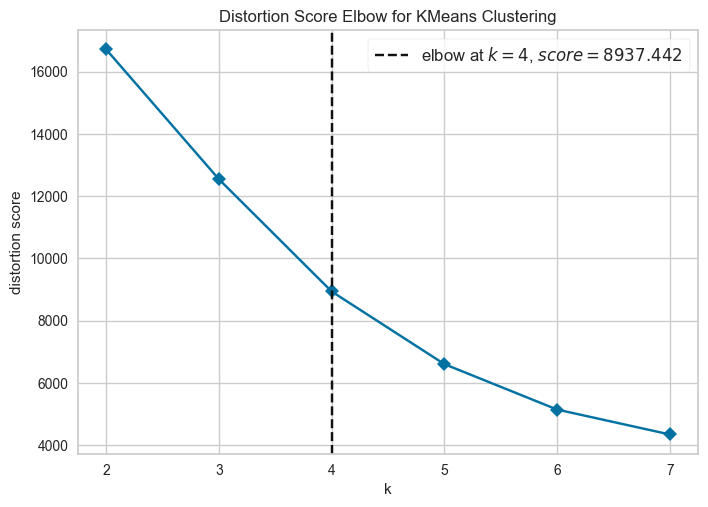

In [231]:
clusters = [2, 3, 4, 5, 6, 7]
kmeans = KElbowVisualizer( c.KMeans(n_init=10), k=clusters, timings=False)
kmeans.fit(X)
kmeans.show();

## 7.2. Silhouette Score

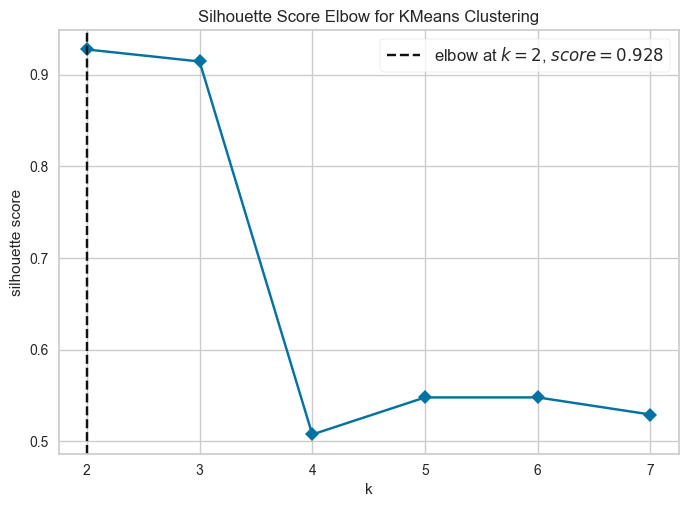

In [232]:
kmeans = KElbowVisualizer(c.KMeans(n_init=10), k=clusters, metric='silhouette', timings=False)
kmeans.fit(X)
kmeans.show();

### 7.2.1 Silhoette Analysis

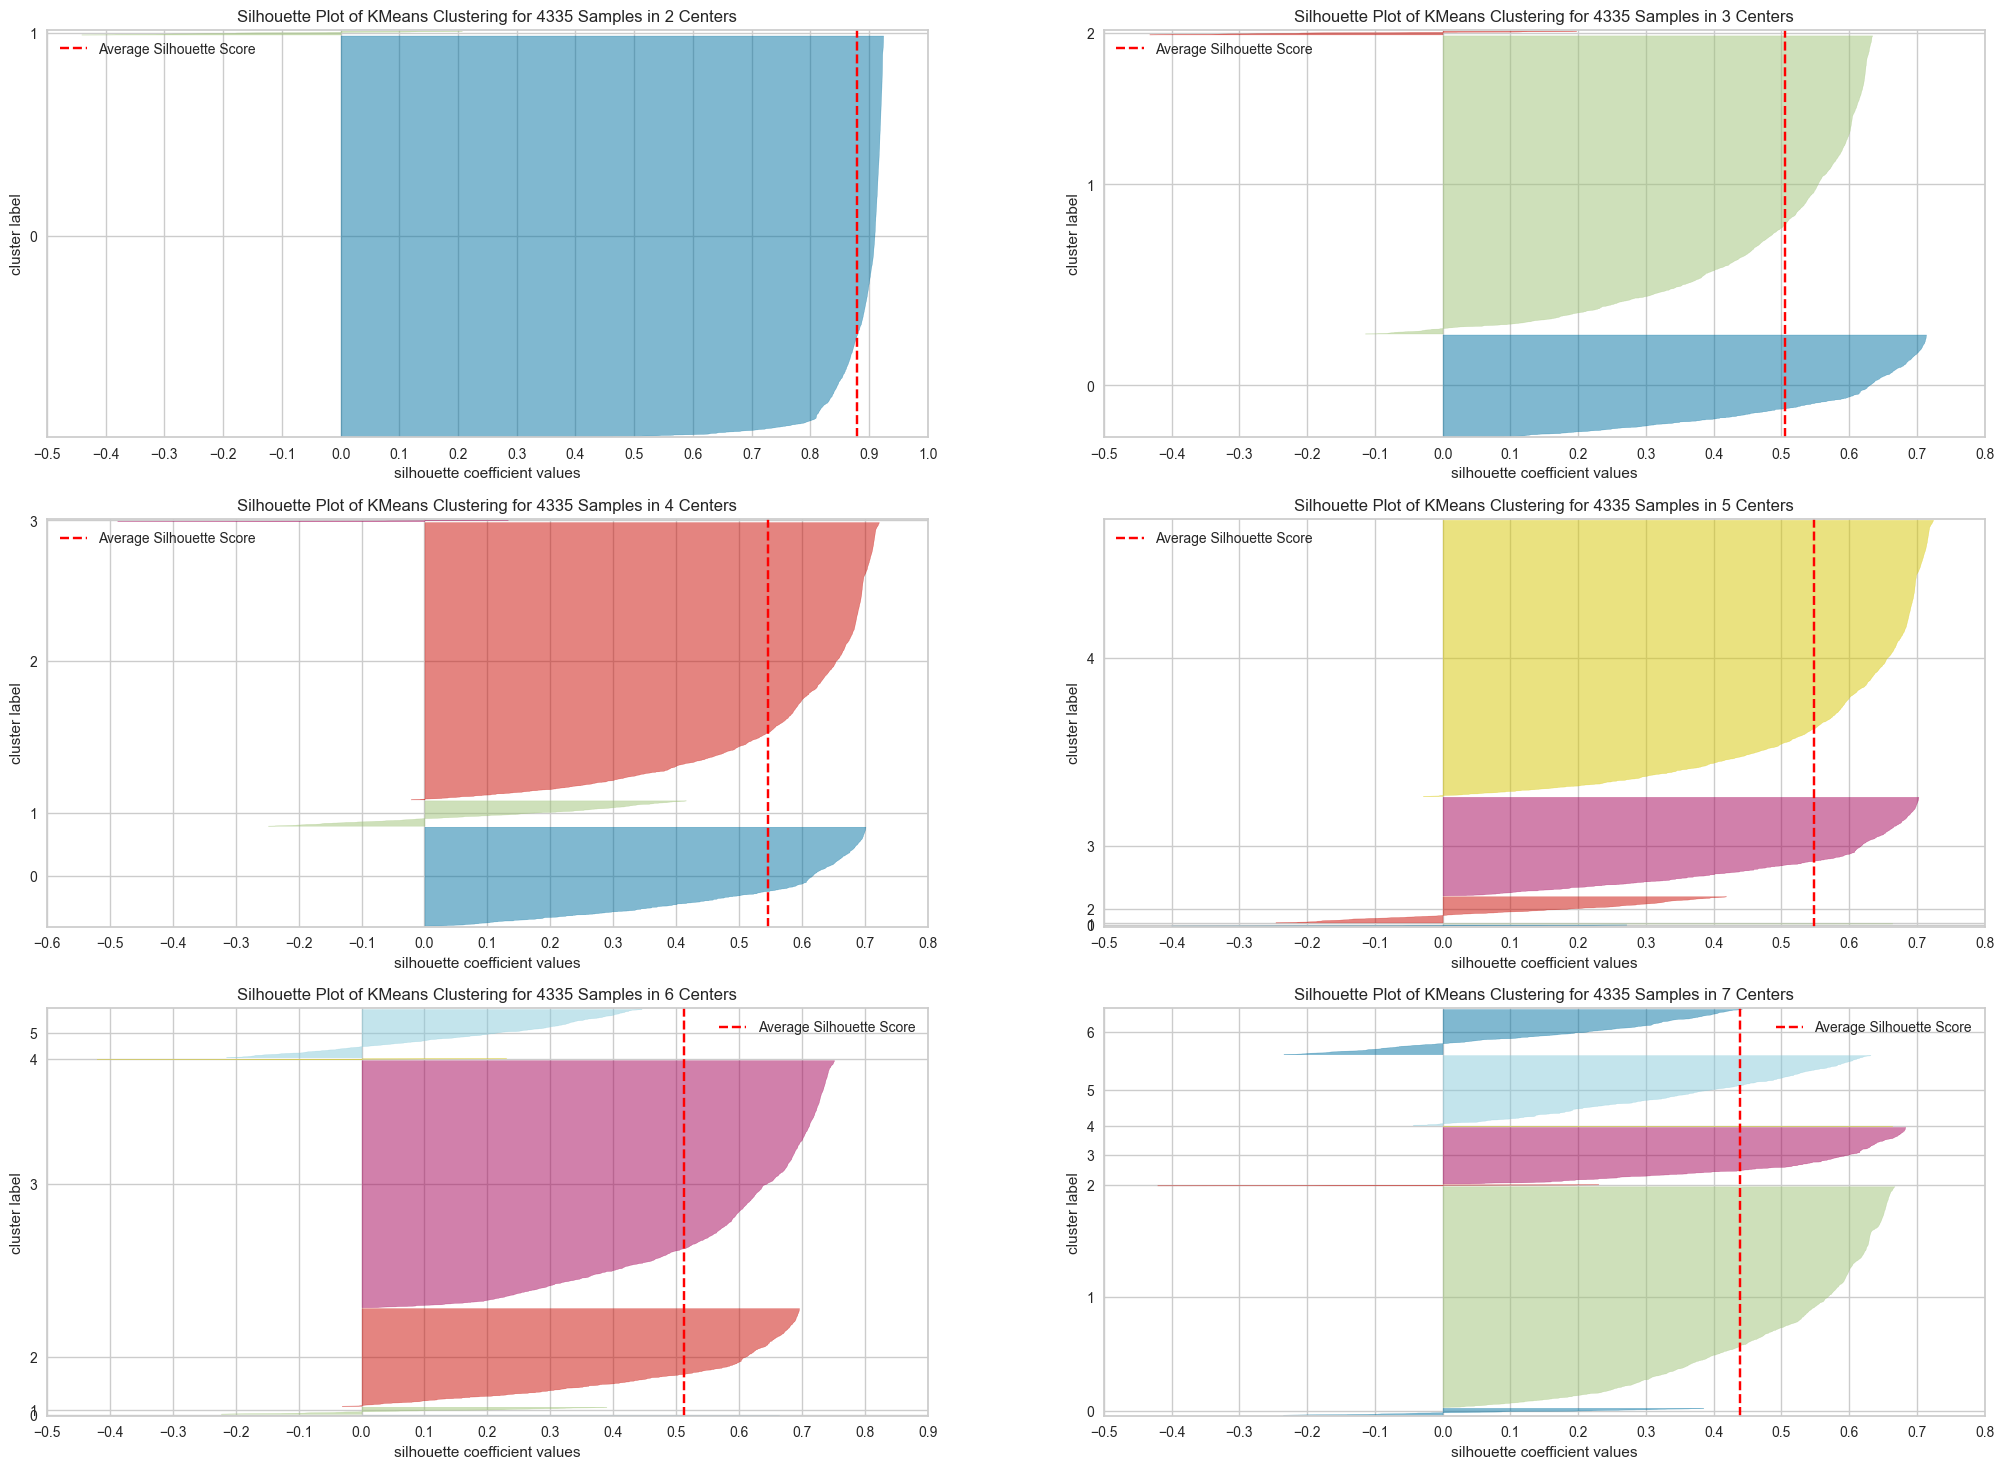

In [233]:
fig, ax = plt.subplots(3, 2, figsize=(25,18))

for k in clusters:
    km = c.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize();

# 8.0. Model Training

## 8.1 KMeans

In [239]:
# model difnition
k = 4
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

### 8.1.1 Cluster Validation

In [240]:
## WSS
print(f'WSS value: {kmeans.inertia_}')

## SS (Silhouette Score)
print('SS value: {}'.format(m.silhouette_score(X, labels, metric='euclidean')))

WSS value: 10489.750577409233
SS value: 0.5466207065096579


# 9.0. Cluster Analysis

## 9.1. Visualization Inspection

c:\Users\Victor\Desktop\repos\pa005_clustering\clustering\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


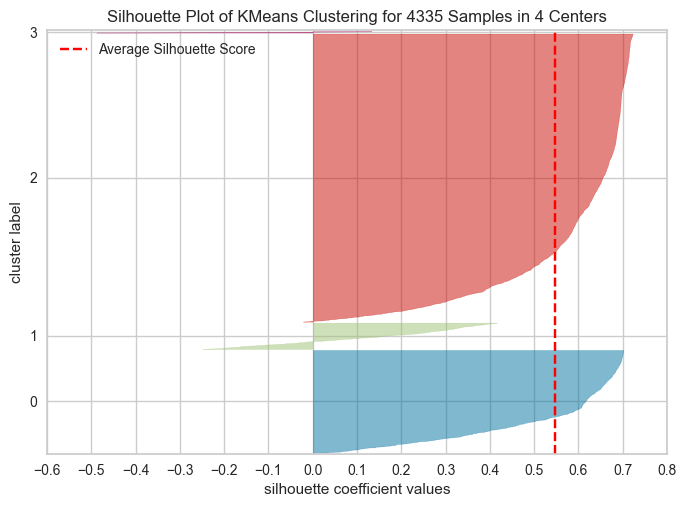

In [241]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize();

### 9.1.1 2d plot

In [242]:
df9 = df6.copy()
df9['cluster'] = labels
df9['cluster'] = df9['cluster'].astype('int64')
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,returns,cluster
0,17850.0,0.377555,2.792291,3.891594,-0.033914,0.114969,0
1,13047.0,0.135617,-0.361628,0.621543,-0.033402,3.160125,1
2,12583.0,0.524847,-0.900589,1.406356,-0.026593,0.622495,1
3,13748.0,-0.120412,0.027621,0.098335,-0.023213,-0.392557,2
4,15100.0,-0.128510,2.403041,-0.163269,0.152575,1.130021,0


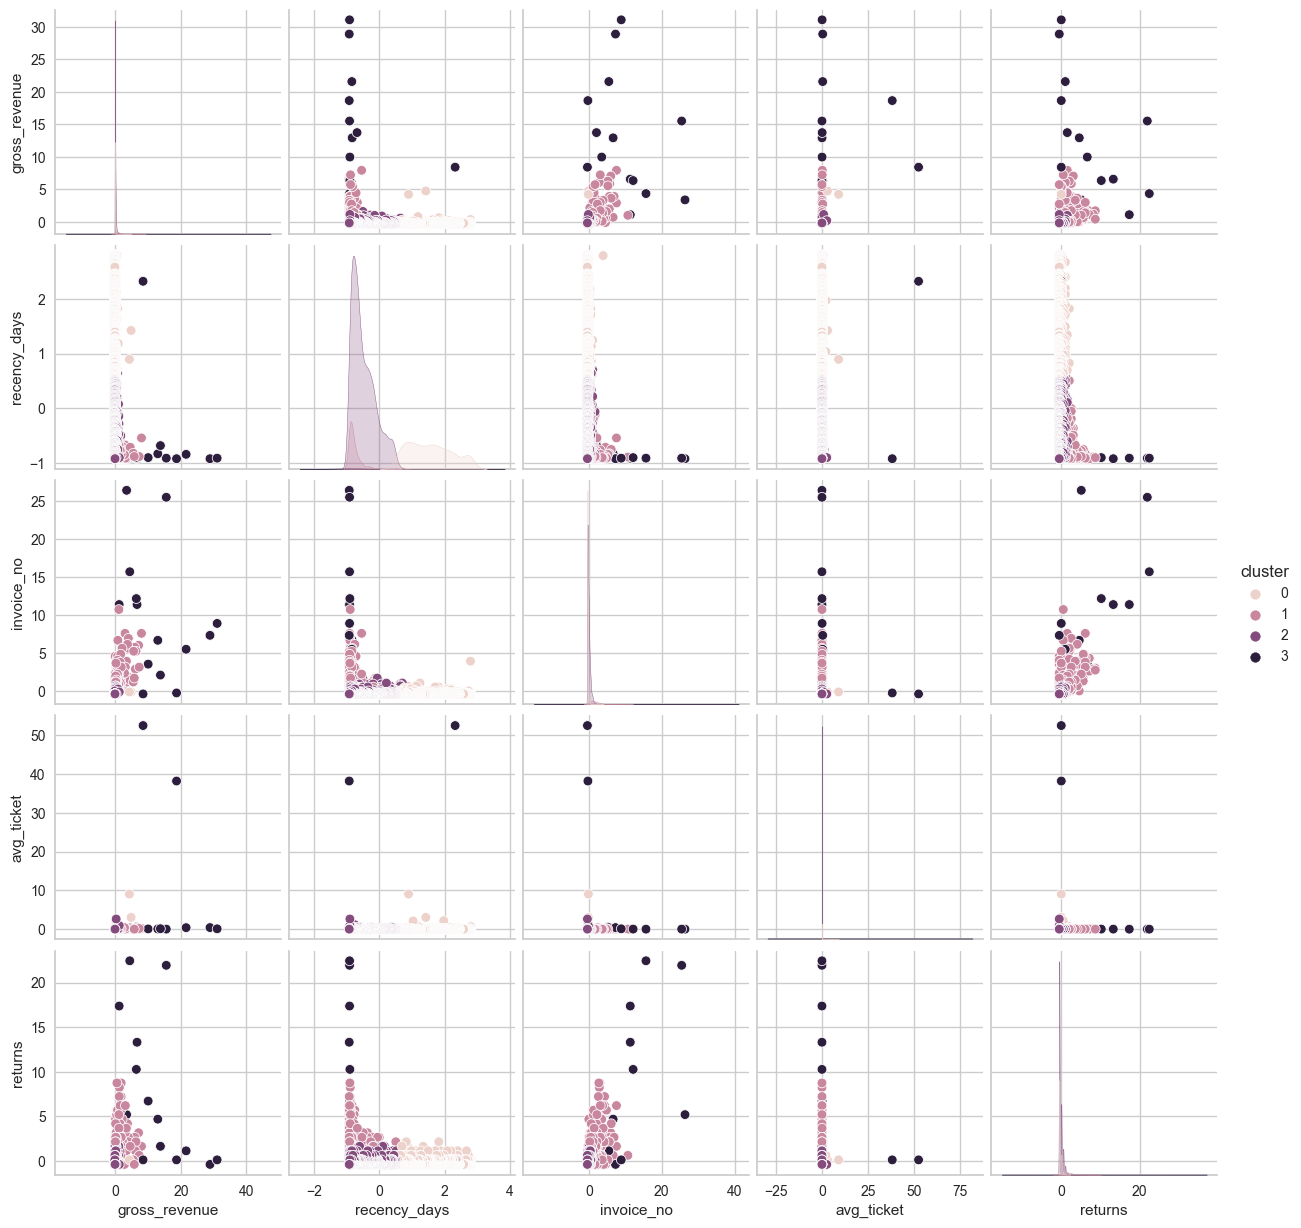

In [246]:
df_viz = df9.drop(columns='customer_id', axis=1)

sns.pairplot(df_viz, hue='cluster');

### 9.1.2 UMAP

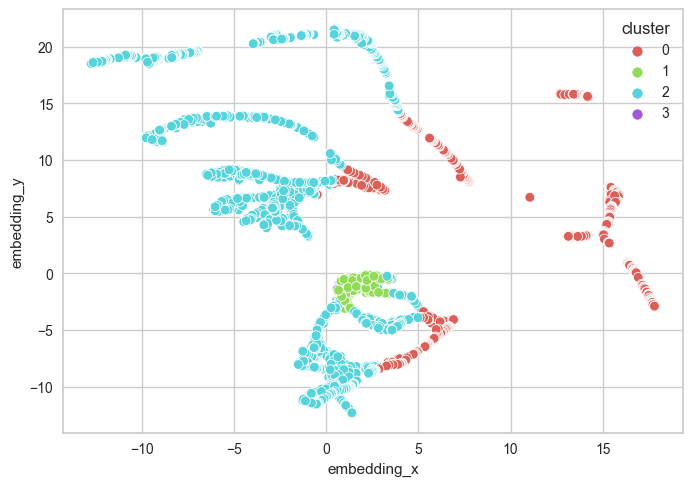

In [245]:
reducer = umap.UMAP(n_neighbors= 20,  random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot
sns.scatterplot(x='embedding_x', y='embedding_y', data = df_viz, hue='cluster', palette=sns.color_palette('hls', n_colors = len(df_viz['cluster'].unique())));

## 9.2. Cluster Profile

In [43]:
# Number of customer
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100*(df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# Avg Gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Avg recency days
df_avg_recency_days = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how='left', on='cluster')

# Avg invoice_no
df_invoice_no = df9[['invoice_no', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_invoice_no, how='inner', on='cluster')

# Avg Ticket
df_ticket = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_ticket, how='inner', on='cluster')

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,38,0.869167,23181.925000,12.868421,43.078947,144.283757
1,1,3,0.068618,241136.560000,3.000000,64.666667,420.140475
2,2,15,0.343092,71423.516000,7.400000,67.866667,147.055408
3,3,3896,89.112534,817.913748,99.906057,3.322382,24.120000
4,4,420,9.606587,5804.281619,25.119048,15.230952,55.151451
